<a href="https://colab.research.google.com/github/simplifique-treinamentos/notebooks-python/blob/main/Estrat%C3%A9gias_de_Imputa%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estratégias de Imputação para Dados Ausentes (*Missing*)

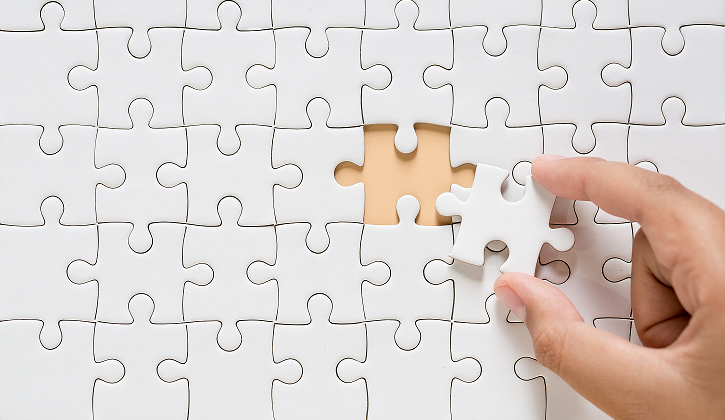

créditos: jcomp - freepik.com

A imputação consiste em preencher os dados ausentes com algum valor. Este processo é extremamente importante, pois algums algoritmos de *machine learning* (ML) não suportam dados ausentes (*missing*). 
<br/><br/>

Uma alternativa quando temos milhares de registros, seria excluir os registros e manter somente os registro completos. No entanto, quando temos poucos registros, por exemplo menos de 1000 registros, como em muitos casos da área da saúde =( , cada registro importa e devemos tentar manter o máximo de registros possíveis para treinarmos um modelo eficaz de ML.
<br/><br/>
A seguir, mostraremos algumas técnicas famosas de imputação

**Inicialmente carregamos as bibliotecas necessárias**

In [50]:
import pandas as pd
import numpy as np

#biblioteca para visualizar dados ausentes
import missingno as msno 

#biblioteca para realizar a imputação
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

#Importo o LabelEncoder para realizar a codificação de variáveis categóricas em números
from sklearn.preprocessing import LabelEncoder

pd.options.mode.chained_assignment = None

**Em seguida, carregamos um dataframe ou criamos um de exemplo**

In [51]:
df = pd.DataFrame([
                    [95, np.nan, 30, np.nan],
                    [106, 2.05, 25.22, 'M'],
                    [90, 1.83, 26.87, 'M'],
                    [72, 1.71, np.nan, 'M'],
                    [np.nan, 1.72, 24.68, 'M'],
                    [63, 1.68, 22.32, 'F'],
                    [75, 1.70, 25.95, 'F'],
                    [55, 1.60, 21.48, 'F'],
                    [59, 1.62, 22.48 , np.nan],
                    [65, 1.55, 27.06, 'F']
                    ],
                  columns = ['peso','altura','imc','sexo'])
df.head(10)

,peso,altura,imc,sexo
0,95.0,NaN,30.00,NaN
1,106.0,2.05,25.22,M
2,90.0,1.83,26.87,M
3,72.0,1.71,NaN,M
4,NaN,1.72,24.68,M
5,63.0,1.68,22.32,F
6,75.0,1.70,25.95,F
7,55.0,1.60,21.48,F
8,59.0,1.62,22.48,NaN
9,65.0,1.55,27.06,F


Os dados ausentes são representados pelos valores ***NaN*** do dataframe que são um acrônimo para Not a Number (NaN).
<br/><br/>
Obs: **Os dados são totalmente fictícios** apenas para exemplificação. O IMC é o cálculo de Índice de Massa Corporal (IMC) que possui a seguinte fórmula: <br/>
$$
\frac{peso}{(altura*altura)}
$$

# 1) Visualização de dados ausentes

Usaremos a biblioteca missingno para facilitar a visualização de dados ausentes. Ela é muito útil quando temos milhares de linhas, mostrando de forma geral as falhas dos conjunto de dados

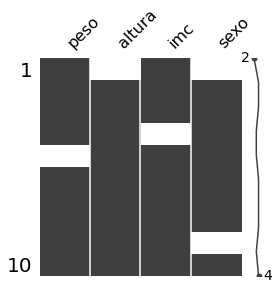

In [52]:
## 1.1) Visualizo os dados missing
msno.matrix(df, figsize=(4, 4));

In [53]:
#Verifico os tipos dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   peso    9 non-null      float64
 1   altura  9 non-null      float64
 2   imc     9 non-null      float64
 3   sexo    8 non-null      object 
dtypes: float64(3), object(1)
memory usage: 448.0+ bytes


Também podemos contabilizar os dados ausentes de forma numérica...

In [54]:
df.isna().sum()

peso      1
altura    1
imc       1
sexo      2
dtype: int64

## 1.1) Imputação usando a biblioteca pandas

In [55]:
df_imputation_pandas = df.copy(deep=True)

In [56]:
df_imputation_pandas.head(10)

,peso,altura,imc,sexo
0,95.0,NaN,30.00,NaN
1,106.0,2.05,25.22,M
2,90.0,1.83,26.87,M
3,72.0,1.71,NaN,M
4,NaN,1.72,24.68,M
5,63.0,1.68,22.32,F
6,75.0,1.70,25.95,F
7,55.0,1.60,21.48,F
8,59.0,1.62,22.48,NaN
9,65.0,1.55,27.06,F


O exemplo a seguir realiza a imputação dos valores ausentes da coluna "peso" pela média de todos os valores da coluna. <br /><br />
Este é um exemplo bem simples e prático para reaproveitarmos as linhas com algum valor *missing*
<br/><br/>
Obs: Para variáveis com muitos valores fora do esperado (*outliers*), uma melhor estratégia seria imputar pela **mediana** (median).

In [57]:
df_imputation_pandas['peso'] = df_imputation_pandas['peso'].fillna(df_imputation_pandas['peso'].mean())
df_imputation_pandas['peso'].head(10)

0     95.000000
1    106.000000
2     90.000000
3     72.000000
4     75.555556
5     63.000000
6     75.000000
7     55.000000
8     59.000000
9     65.000000
Name: peso, dtype: float64

Perceba que a célula do indice 4, agora ficou com o valor 75.55 que é a média de todas os valores de peso.

## 1.2) Exclusão de registros com dados ausentes

Uma opção **NÃO muito recomendada** é excluir as linhas (registros) com algum valor ausente. <br /><br />
Caso nosso conjunto de dados tenha muuuuuitos registros (acima de 10000), isso não será um problema. No entanto, para pequenos conjuntos de dados, pode prejudicar nossa análise, e principalmente prejudicar o ajuste de um modelo preditivo de machine learning (ML).

In [59]:
df_excluir_missing = df_imputation_pandas.copy(deep=True)

In [60]:
df_excluir_missing.shape

(10, 4)

In [61]:
#Exclui todas as linhas (axis=0) com alguma célula com dado ausentes
df_excluir_missing.dropna(axis=0, how='any',inplace=True)

*   O parâmetro 'axis' determina se é para excluir a linha (axis=0) ou a coluna (axis=1)
*   O parâmetro 'how' determina se é para excluir com algum célula não preenchida (any) ou se a linha ou coluna estiver completamente não preenchida (all)
*   O parâmetro inplance determina se é para fazer no próprio dataframe (True) ou na cópia ou view (False)

In [62]:
df_excluir_missing.shape

(7, 4)

Perceba que 3 linhas foram excluidas do dataset, pois continham algumas das células com dados ausentes

In [63]:
df_excluir_missing.head(10)

,peso,altura,imc,sexo
1,106.000000,2.05,25.22,M
2,90.000000,1.83,26.87,M
4,75.555556,1.72,24.68,M
5,63.000000,1.68,22.32,F
6,75.000000,1.70,25.95,F
7,55.000000,1.60,21.48,F
9,65.000000,1.55,27.06,F


# 2) Realizando a Imputação com *Imputers*

##2.1) Simple Imputer

O **Simple Imputer**, como o própria nome sugere, faz a imputação usando estratégias simples como a **média ou mediana** para variáveis contínuas e **moda** (*most_frequent*) ou um **valor fixo** (*constant*) para variáveis categóricas. 
<br /><br />
A seguir veremos um exemplo de imputação pela média.
<hr/>

### 2.1.1) Imputação pela Média nas variáveis quantitativas

**Defino a estratégia de imputação para as variáveis numéricas**

In [64]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

*   O parâmetro missing_values determina o que é considerado dado ausente. O padrão é np.nan, mas poderia ser valores 0.
*   O parâmetro strategy determina a estratégia de imputação. Pode ser média (mean) e mediana (median) para dados quantitativos (números contínuos) ou a moda (most_frequent) e um valor fixo (constant) para dados qualitativos (categorias ou textos).

In [65]:
#Filtro somente as colunas numéricas
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
num_cols

Index(['peso', 'altura', 'imc'], dtype='object')

In [66]:
#Faço um cópia do DataFrame original para manter o histórico do que foi feito
df_imputation = df.copy(deep=True)

A seguir realizaremos a imputação para TODAS as colunas numéricas usando a média de cada coluna...

In [67]:
####################
#DataFrame original
####################
print("DataFrame Original (antes da imputação)\n")
print(df)

###############################################################
#Realizo a imputação usando o imputador simples (simple_imputer)
###############################################################
#Usamos o método fit_transform() que já realiza o ajuste às colunas numéricas e altera (transform) os valores em missing para a média 
#Obs: Também é possível executar separadamente os métodos fit() e transform()
df_imputation[num_cols]  = simple_imputer.fit_transform(df_imputation[num_cols])

print("\nDepois da imputação, sem imputar as variáveis categóricas...\n")
df_imputation.head(10)

DataFrame Original (antes da imputação)

    peso  altura    imc sexo
0   95.0     NaN  30.00  NaN
1  106.0    2.05  25.22    M
2   90.0    1.83  26.87    M
3   72.0    1.71    NaN    M
4    NaN    1.72  24.68    M
5   63.0    1.68  22.32    F
6   75.0    1.70  25.95    F
7   55.0    1.60  21.48    F
8   59.0    1.62  22.48  NaN
9   65.0    1.55  27.06    F

Depois da imputação, sem imputar as variáveis categóricas...



,peso,altura,imc,sexo
0,95.000000,1.717778,30.000000,NaN
1,106.000000,2.050000,25.220000,M
2,90.000000,1.830000,26.870000,M
3,72.000000,1.710000,25.117778,M
4,75.555556,1.720000,24.680000,M
5,63.000000,1.680000,22.320000,F
6,75.000000,1.700000,25.950000,F
7,55.000000,1.600000,21.480000,F
8,59.000000,1.620000,22.480000,NaN
9,65.000000,1.550000,27.060000,F


**Para confirmar se os valores foram imputados corretamente, calculo as médias de todas as colunas**

In [68]:
df.select_dtypes(include=["float64", "int64"]).apply(np.nanmean).head()

peso      75.555556
altura     1.717778
imc       25.117778
dtype: float64

Obs: Note que a média de cada coluna **numérica** foi inserida nas células que estavam com valores ***NaN***

Perceba que em alguns casos, usar a média pode não ser o mais adequado, pois colocamos um valor fixo sem considerar as demais variáveis do dataframe que possam ter alguma relação com o valor da variável imputada.  
<br> 
Um exemplo de problema ao usar a média seria o IMC calculado para a linha com índice 2 que deveria ser 24.62, mas ao usar a média, foi inserido um valor  mais alto de 25.11.

### 2.1.2) Imputação pela Moda nas variáveis qualitativas (categóricas)

**Imputando as variáveis categóricas**

A seguir, definimos a estratégia de imputação pela moda (valor mais frequente) para a coluna sexo

In [72]:
#Defino a estratégia de imputação para as variáveis categóricas (most_frequent = Moda)
simple_imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [73]:
#Filtro somente as colunas categóricas
cat_cols = df_imputation.select_dtypes(include=["object"]).columns
cat_cols

Index(['sexo'], dtype='object')

In [74]:
#DataFrame original
print("DataFrame com a imputação de variáveis numéricas\n")
print(df_imputation)

#Realizo a imputação usando o imputador (simple_imputer)
#Inicialmente defino as colunas que serão imputadas com o método fit()
simple_imputer_cat = simple_imputer_cat.fit(df_imputation[cat_cols])

#Em seguida realizo a imputação usando o método transform().
df_imputation[cat_cols] = simple_imputer_cat.transform(df_imputation[cat_cols])

print("\nDepois da imputação, agora com a imputação das variáveis categóricas...\n")
df_imputation.head(10)

DataFrame com a imputação de variáveis numéricas

         peso    altura        imc sexo
0   95.000000  1.717778  30.000000    F
1  106.000000  2.050000  25.220000    M
2   90.000000  1.830000  26.870000    M
3   72.000000  1.710000  25.117778    M
4   75.555556  1.720000  24.680000    M
5   63.000000  1.680000  22.320000    F
6   75.000000  1.700000  25.950000    F
7   55.000000  1.600000  21.480000    F
8   59.000000  1.620000  22.480000    F
9   65.000000  1.550000  27.060000    F

Depois da imputação, agora com a imputação das variáveis categóricas...



,peso,altura,imc,sexo
0,95.000000,1.717778,30.000000,F
1,106.000000,2.050000,25.220000,M
2,90.000000,1.830000,26.870000,M
3,72.000000,1.710000,25.117778,M
4,75.555556,1.720000,24.680000,M
5,63.000000,1.680000,22.320000,F
6,75.000000,1.700000,25.950000,F
7,55.000000,1.600000,21.480000,F
8,59.000000,1.620000,22.480000,F
9,65.000000,1.550000,27.060000,F


Perceba que foi imputado o mesmo valor 'F' para as linhas 0 e 8. Isso porque, nessa estratégia de imputação simples, não são consideradas as demais colunas do dataframe. Veremos a seguir outra estratégia mais elaborada de imputação.

## 2.2) KNN Imputer

O KNN imputer realiza a imputação usando o classificador k-Nearest Neighbor em que os valores são estimados de acordo com a média dos *vizinhos* mais próximos (padrão de 5 vizinhos). Os *vizinhos* são os registros mais próximos usando métricas como a distância euclidiana entre os valores de cada registro.

<br/>
Mais detalhes em:

*   https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/

In [78]:
#Faço um cópia do DataFrame original para manter o histórico do que foi feito
df_imputation_knn = df.copy(deep=True)
df_imputation_knn.head(10)

,peso,altura,imc,sexo
0,95.0,NaN,30.00,NaN
1,106.0,2.05,25.22,M
2,90.0,1.83,26.87,M
3,72.0,1.71,NaN,M
4,NaN,1.72,24.68,M
5,63.0,1.68,22.32,F
6,75.0,1.70,25.95,F
7,55.0,1.60,21.48,F
8,59.0,1.62,22.48,NaN
9,65.0,1.55,27.06,F


In [79]:
#Verifico os tipos de dados da cópia
df_imputation_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   peso    9 non-null      float64
 1   altura  9 non-null      float64
 2   imc     9 non-null      float64
 3   sexo    8 non-null      object 
dtypes: float64(3), object(1)
memory usage: 448.0+ bytes


###2.2.1) Imputação das variáveis quantitativas

In [80]:
#####################
#Antes da imputação
#####################
#DataFrame original
print("DataFrame Original (antes da imputação)\n")
print(df)

#Utilizo o KNN inicialmente apenas para as variáveis numéricas
knn_imputer_num = KNNImputer(n_neighbors=2)

#Realizo a imputação usando o imputador knn_imputer_num
knn_imputer_num = knn_imputer_num.fit(df_imputation_knn[num_cols])
df_imputation_knn[num_cols] = knn_imputer_num.transform(df_imputation_knn[num_cols])

df_imputation_knn.head(10)

DataFrame Original (antes da imputação)

    peso  altura    imc sexo
0   95.0     NaN  30.00  NaN
1  106.0    2.05  25.22    M
2   90.0    1.83  26.87    M
3   72.0    1.71    NaN    M
4    NaN    1.72  24.68    M
5   63.0    1.68  22.32    F
6   75.0    1.70  25.95    F
7   55.0    1.60  21.48    F
8   59.0    1.62  22.48  NaN
9   65.0    1.55  27.06    F


,peso,altura,imc,sexo
0,95.0,1.775,30.000,NaN
1,106.0,2.050,25.220,M
2,90.0,1.830,26.870,M
3,72.0,1.710,25.315,M
4,89.0,1.720,24.680,M
5,63.0,1.680,22.320,F
6,75.0,1.700,25.950,F
7,55.0,1.600,21.480,F
8,59.0,1.620,22.480,NaN
9,65.0,1.550,27.060,F


### 2.2.2) Imputação das variáveis categóricas

**Para as variáveis categóricas, precisamos inicialmente codificar as variáveis em números, pois o KNNImputer somente trabalha com números pois usa o cálculo da distância euclidiana (*default*)**

In [81]:
# crio o objeto para realizar a codificação
label_encoder = LabelEncoder()

#Extraio somente as linhas sem valores nulos, para não criar uma categoria nova para valores nulos
array_not_nulls = np.array(df_imputation_knn[cat_cols].dropna())
array_not_nulls

array([['M'],
       ['M'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['F']], dtype=object)

In [82]:
#Realizo a codificação usando o label_encoder
array_dados_transformados = label_encoder.fit_transform(np.ravel(array_not_nulls))
array_dados_transformados

array([1, 1, 1, 1, 0, 0, 0, 0])

In [83]:
#Atribuo os valores transformados ao dataframe
#Primeiro, localizo as linhas com dados nao nulos e depois atribuo os valores transformados
df_imputation_knn.sexo.loc[df_imputation_knn.sexo.notnull()] = array_dados_transformados
df_imputation_knn.head(10)

,peso,altura,imc,sexo
0,95.0,1.775,30.000,NaN
1,106.0,2.050,25.220,1
2,90.0,1.830,26.870,1
3,72.0,1.710,25.315,1
4,89.0,1.720,24.680,1
5,63.0,1.680,22.320,0
6,75.0,1.700,25.950,0
7,55.0,1.600,21.480,0
8,59.0,1.620,22.480,NaN
9,65.0,1.550,27.060,0


Perceba que mantivemos os valores ausentes, pois usaremos o KNNImputer para realizar a imputação nestas células!

**Crio um objeto KNNImputer para imputação das colunas categóricas**

In [84]:
knn_imputer_cat = KNNImputer(n_neighbors=2)

#Realizo a imputação
df_imputation_knn = pd.DataFrame(knn_imputer_cat.fit_transform(df_imputation_knn), 
                                 index=df_imputation_knn.index, 
                                 columns=df_imputation_knn.columns)
df_imputation_knn.head(10)

,peso,altura,imc,sexo
0,95.0,1.775,30.000,1.0
1,106.0,2.050,25.220,1.0
2,90.0,1.830,26.870,1.0
3,72.0,1.710,25.315,1.0
4,89.0,1.720,24.680,1.0
5,63.0,1.680,22.320,0.0
6,75.0,1.700,25.950,0.0
7,55.0,1.600,21.480,0.0
8,59.0,1.620,22.480,0.0
9,65.0,1.550,27.060,0.0


In [85]:
df_imputation_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   peso    10 non-null     float64
 1   altura  10 non-null     float64
 2   imc     10 non-null     float64
 3   sexo    10 non-null     float64
dtypes: float64(4)
memory usage: 448.0 bytes


Obs: Note que agora a variável **sexo** foi imputada com valores diferentes para o primeiro e o oitavo registro!

## 2.3) Iterative Imputer (MICE)

O Iterative Imputer estima cada variável criando um classificador com as demais variáveis.  Por padrão usa-se o classificador BayesianRidge. 
<br/><br/>
É como se criássemos um modelo preditivo e o desfecho fosse a coluna com variáveis missing. Ele faz este processo para cada coluna com dados missing.
<br/><br/>
Veja mais em:
*    https://www.jstatsoft.org/article/view/v045i03
*    https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
*    https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

In [86]:
#Faço um cópia do DataFrame original para manter o histórico do que foi feito
df_imputation_iterative = df.copy(deep=True)
df_imputation_iterative.head(10)

,peso,altura,imc,sexo
0,95.0,NaN,30.00,NaN
1,106.0,2.05,25.22,M
2,90.0,1.83,26.87,M
3,72.0,1.71,NaN,M
4,NaN,1.72,24.68,M
5,63.0,1.68,22.32,F
6,75.0,1.70,25.95,F
7,55.0,1.60,21.48,F
8,59.0,1.62,22.48,NaN
9,65.0,1.55,27.06,F


In [87]:
num_cols

Index(['peso', 'altura', 'imc'], dtype='object')

###2.3.1) Imputação das variáveis quantitativas

In [88]:
#####################
# Antes da imputação
#####################
print(df)
  
# Crio o imputer para as variáveis quantitativas com os valores default
iterative_imputer_num = IterativeImputer(estimator=BayesianRidge(), initial_strategy='mean')

# imputing the missing value with mice imputer
#Realizo a imputação usando o imputador knn_imputer_num
iterative_imputer_num = iterative_imputer_num.fit(df_imputation_iterative[num_cols])
df_imputation_iterative[num_cols] = iterative_imputer_num.transform(df_imputation_iterative[num_cols])

df_imputation_iterative.head(10)

    peso  altura    imc sexo
0   95.0     NaN  30.00  NaN
1  106.0    2.05  25.22    M
2   90.0    1.83  26.87    M
3   72.0    1.71    NaN    M
4    NaN    1.72  24.68    M
5   63.0    1.68  22.32    F
6   75.0    1.70  25.95    F
7   55.0    1.60  21.48    F
8   59.0    1.62  22.48  NaN
9   65.0    1.55  27.06    F


,peso,altura,imc,sexo
0,95.000000,1.79666,30.000000,NaN
1,106.000000,2.05000,25.220000,M
2,90.000000,1.83000,26.870000,M
3,72.000000,1.71000,24.789128,M
4,73.859033,1.72000,24.680000,M
5,63.000000,1.68000,22.320000,F
6,75.000000,1.70000,25.950000,F
7,55.000000,1.60000,21.480000,F
8,59.000000,1.62000,22.480000,NaN
9,65.000000,1.55000,27.060000,F


O Iterative Imputer utilizou as demais variáveis para criar um modelo preditivo usando como desfecho cada variável ausente. Neste exemplo, o valor estimado do IMC para o registro de índice 2 foi de 24.78, **muito próximo do valor real** que seria calculado de 24.62

### 2.3.2) Imputação das variáveis categóricas

In [90]:
# crio o objeto para realizar a codificação da variável categórica
label_encoder = LabelEncoder()

#Extraio somente as linhas sem valores nulos, para não criar uma categoria nova para valores nulos
array_not_nulls = np.array(df_imputation_iterative[cat_cols].dropna())
array_not_nulls

array([['M'],
       ['M'],
       ['M'],
       ['M'],
       ['F'],
       ['F'],
       ['F'],
       ['F']], dtype=object)

In [91]:
#Realizo a codificação usando o label_encoder
array_dados_transformados = label_encoder.fit_transform(np.ravel(array_not_nulls))
array_dados_transformados

array([1, 1, 1, 1, 0, 0, 0, 0])

In [92]:
#Atribuo os valores transformados ao dataframe
#Primeiro, localizo as linhas com dados nao nulos e depois atribuo os valores transformados
df_imputation_iterative.sexo.loc[df_imputation_iterative.sexo.notnull()] = array_dados_transformados
df_imputation_iterative.head(10)

,peso,altura,imc,sexo
0,95.000000,1.79666,30.000000,NaN
1,106.000000,2.05000,25.220000,1
2,90.000000,1.83000,26.870000,1
3,72.000000,1.71000,24.789128,1
4,73.859033,1.72000,24.680000,1
5,63.000000,1.68000,22.320000,0
6,75.000000,1.70000,25.950000,0
7,55.000000,1.60000,21.480000,0
8,59.000000,1.62000,22.480000,NaN
9,65.000000,1.55000,27.060000,0


In [93]:
iterative_imputer_cat = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=2), initial_strategy='most_frequent')

#Realizo a imputação
df_imputation_iterative = pd.DataFrame(iterative_imputer_cat.fit_transform(df_imputation_iterative), 
                                        index=df_imputation_iterative.index, 
                                        columns=df_imputation_iterative.columns)
df_imputation_iterative.head(10)

,peso,altura,imc,sexo
0,95.000000,1.79666,30.000000,1.0
1,106.000000,2.05000,25.220000,1.0
2,90.000000,1.83000,26.870000,1.0
3,72.000000,1.71000,24.789128,1.0
4,73.859033,1.72000,24.680000,1.0
5,63.000000,1.68000,22.320000,0.0
6,75.000000,1.70000,25.950000,0.0
7,55.000000,1.60000,21.480000,0.0
8,59.000000,1.62000,22.480000,0.0
9,65.000000,1.55000,27.060000,0.0


# 3) Próximos passos


* Além da imputação, é recomendado **ajustar a escala** das variáveis para evitar algum viés de algum algoritmo de imputação que utiliza métricas como a distância euclidiana (ex: KNNImputer).


* É possível utilizar **pipelines** para automatizar o processo de imputação e padronização.

* Obs: Se você for realizar a imputação para **treinar modelos de machine learning**, o ideal é realizar a i**mputação de forma separada** para dados de **treinamento** e dados de **testes** para evitar vazamento de dados.

#4) Referências


*   SimpleImputer - https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
*   KNNImputer - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
*   IterativeImputer - https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html



Obrigado!